In [1]:
%matplotlib inline
from IPython import display
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
#     display.set_matplotlib_formats()
    plt.show()

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

#读取数据并且返回训练集和测试集
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="D:/书籍资料整理/torch_data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="D:/书籍资料整理/torch_data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    #animator绘制动图用的
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        #每迭代周期
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        #每迭代周期的损失函数
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            #反向传播
            l.sum().backward()
            #梯度下降并且更新参数
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [2]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
# 展平层指的就是输入的图片是28*28的,给展nn.Linear开成向量
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [3]:
#定义损失函数
loss = nn.CrossEntropyLoss()
#优化器,梯度下降,lr=0.1
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

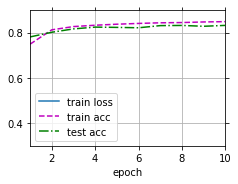

In [4]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)